# How well does our MMP study design hold up to the assumptions required for causal interpretation?

See https://docs.google.com/document/d/1AoupJlYlt1a13fflt4bv4jiiCpPxHV41Q1C1N0z9TzQ/edit# for a description of the study design and assumptions. See `sample_identification.ipynb` for breakdowns of groups used for these tests.

Author: Ryan Treves

In [24]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
import scipy.stats as ss
import statsmodels.stats.proportion as ssp
import seaborn as sns

# display all rows & columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# display all columns
pd.set_option('display.max_columns', None)

# turn off warning messages
warnings.filterwarnings('ignore')

Read in data

In [2]:
# Set file paths
data_path = '~/sherlock_oak/EPA/Data/manual/california/'

# Read in data
violations = pd.read_excel(data_path + 'violations_export_2021-10-26.xlsx', dtype={'FACILITY_ID': str},
                           parse_dates=['OCCURRED ON', 'EFFECTIVE DATE', 'TERMINATION DATE'], date_parser=lambda x: pd.to_datetime(x, errors='coerce'))

enforcements = pd.read_csv(data_path + 'enf_actions_export.csv',
                           dtype={'FACILITY ID': object},
                           parse_dates=['DATE OF OLDEST VIOLATION LINKED TO ENFORCEMENT ACTION', 'EFFECTIVE DATE.1', 'ACL ISSUANCE DATE', 'EPL ISSUANCE DATE'],
                           date_parser=lambda x: pd.to_datetime(x, errors='coerce'))
enforcements.rename(columns={'FACILITY ID': 'FACILITY_ID'}, inplace=True)

# enf_viol_links = pd.read_excel(data_path + 'EnfActionToViolationRships.xlsx', dtype={'Violation ID': object})

# Remove all dismissed violations
violations = violations[violations['STATUS.1'] != 'Dismissed']

## Design 1: Treatment group A, Comparison group B

Treatment group A: facilities which received an EPL between July 1, 2008 and January 22, 2009 for an MMP-eligible effluent violation, and had no prior history of MMP enforcements.
Comparison group B: facilities with MMP-eligible effluent violations pre-2008, for which MMP was consistently enforced pre-2008. Consistent enforcement is defined as an enforcement rate of >75% (see `sample_identification.ipynb`)

In [3]:
# Load in data
treatment_A_facilities = pd.read_csv('/Users/rtreves/Documents/RegLab/python_projects/ca_mmp/policy_eval/groups/treatment_A_facilities.csv', dtype={'0':str}).drop('Unnamed: 0', axis=1).rename(columns={'0':'FACILITY_ID'})
comparison_B_facilities = pd.read_csv('/Users/rtreves/Documents/RegLab/python_projects/ca_mmp/policy_eval/groups/comparison_B_facilities.csv', dtype={'0':str}).drop('Unnamed: 0', axis=1).rename(columns={'0':'FACILITY_ID'})

In [40]:
# This function takes in a comparison group, treatment group, and a column name,
# and returns the top n values of the column in order of the absolute difference
# in composition of the two groups. Streamlines compositional analysis.
def compare_composition(data_a, data_b, column, top_n=3):
    A = pd.DataFrame(data_a[column].value_counts(normalize=True)).rename(columns={column: 'Comparison'})
    B = pd.DataFrame(data_b[column].value_counts(normalize=True)).rename(columns={column: 'Treatment'})
    results = pd.concat([A, B], axis=1)
    results['diff'] = np.abs(results['Comparison'] - results['Treatment'])
    results = results.apply(lambda x: x.round(2))
    results.sort_values(by='diff', inplace=True, ascending=False)
    results = results.reset_index(names='Value').set_index(pd.Index([column] * len(results)))

    # Add p-value
    results['p_value (prop_ztest)'] = np.nan
    results['p_value (fishers_exact_test)'] = np.nan
    for i in range(0, len(results)):
        variable = results.index[i]
        value = results['Value'].iloc[i]
        count_a = len(data_a[data_a[variable] == value])
        count_b = len(data_b[data_b[variable] == value])
        results['p_value (prop_ztest)'].iloc[i] = ssp.proportions_ztest([count_a, count_b],
                                                                                 [len(data_a), len(data_b)],
                                                                                 alternative='two-sided')[1]
        results['p_value (fishers_exact_test)'].iloc[i] = ss.fisher_exact([[count_a, len(data_a)-count_a], [count_b, len(data_b)-count_b]])[1]
    return results.head(top_n)

In [5]:
treatment_A_violations = violations.merge(treatment_A_facilities, on='FACILITY_ID')
comparison_B_violations = violations.merge(comparison_B_facilities, on='FACILITY_ID')

In [6]:
# Deleting objects to save memory
del violations
# del enforcements

A number of our assumptions depend on knowing how many facilities in our groups are active in NPDES at any given time. To do this, we need to determine when a facility entered and exited the population. Here, I define entering population as being issued a NPDES permit. Defining when facilities exit the population is less straightforward: a facility's NPDES permit may expire, but until the permit is renewed or terminated, the permittee may still be discharging and is still regulated under NPDES. Furthermore, the `TERMINATION DATE` listed on a violation record may not actually reflect exit of the population, as the permittee may have switched NPDES subprograms (e.g., from NPDESWW to NPDESNONMUNIPRCS, as in the case of `FACILITY_ID` 261701). Thus, as a heuristic until we can come up with a better way or do everything by hand, I define the date when a facility exists the population as the expiration date of the facility's last NPDES permit, or the latest permit termination date (`TERMINATION DATE`) in the violations record, whichever is latest. In the case that we don't have a permit termination date, the facility is assumed to still be active, and is assigned an estimated exit date of NA. In some cases, violations will still appear after this date, however, they seem to be due to late reporting in all cases.

In [7]:
# Load facility reports for these facilities
facility_reports = pd.read_csv('/Users/rtreves/Documents/RegLab/python_projects/ca_mmp/policy_eval/tAcB_facility_reports.csv', dtype={'FACILITY_ID': str}, parse_dates=['Effective Date', 'Expiration Date'], date_parser=lambda x: pd.to_datetime(x, errors='coerce'))

# Extract NPDES enrollment and exp. Note - even though all facilities in our groups are NPDES permittees, not all have a Reg Measure on file of type `NPDES Permit` - I'm not quite sure why this is, reasons seem to vary from permittee.
facility_reports = facility_reports[facility_reports['Reg Measure Type'] == 'NPDES Permit']
# Extract the oldest permit issuance date and most recent permit expiration date for each facility
facility_reports = facility_reports.groupby('FACILITY_ID', as_index=False).agg(enroll_date=pd.NamedAgg(column='Effective Date', aggfunc=lambda x: x.min()), final_expiration_date=pd.NamedAgg(column='Expiration Date', aggfunc=lambda x: x.max()))

In [8]:
# Merge with violations record on facility
treatment_A_violations = treatment_A_violations.merge(facility_reports, on='FACILITY_ID', how='left')
comparison_B_violations = comparison_B_violations.merge(facility_reports, on='FACILITY_ID', how='left')

In [9]:
# Determine last permit termination dates
last_termination_dates = treatment_A_violations.groupby('FACILITY_ID', as_index=False).agg(last_termination_date=pd.NamedAgg(column='TERMINATION DATE', aggfunc=lambda x: x.max()))
treatment_A_violations = treatment_A_violations.merge(last_termination_dates, on='FACILITY_ID')
last_termination_dates = comparison_B_violations.groupby('FACILITY_ID', as_index=False).agg(last_termination_date=pd.NamedAgg(column='TERMINATION DATE', aggfunc=lambda x: x.max()))
comparison_B_violations = comparison_B_violations.merge(last_termination_dates, on='FACILITY_ID')

In [10]:
# Calculate estimated population entrance date

treatment_A_violations['estimated_entrance_date'] = treatment_A_violations['enroll_date']
comparison_B_violations['estimated_entrance_date'] = comparison_B_violations['enroll_date']

# For facilities which we don't have a NPDES enroll date, take the effective date of the active permit from the violations record
# (though there may be multiple violations, examination of the data reveals all violations share an 'Effective Date' for
# facilities w/o a NPDES enroll date.
for i in range(0, len(treatment_A_violations)):
    if pd.isna(treatment_A_violations['estimated_entrance_date'].iloc[i]):
        treatment_A_violations['estimated_entrance_date'].iloc[i] = treatment_A_violations['EFFECTIVE DATE'].iloc[i]
for i in range(0, len(comparison_B_violations)):
    if pd.isna(comparison_B_violations['estimated_entrance_date'].iloc[i]):
        comparison_B_violations['estimated_entrance_date'].iloc[i] = comparison_B_violations['EFFECTIVE DATE'].iloc[i]

# Convert estimated entrance date to a quarter. There are still some cases where we don't have an 'EFFECTIVE DATE' or an enroll_date,
# in which case dt.to_period() returns a negative value. So we need to manually set the 'Enroll quarter' value to NaN.
treatment_A_violations['estimated_entrance_quarter'] = treatment_A_violations['estimated_entrance_date'].dt.to_period('Q').astype(int)
treatment_A_violations['estimated_entrance_quarter'] = treatment_A_violations['estimated_entrance_quarter'].apply(lambda x: np.nan if (x < 0) else x)
comparison_B_violations['estimated_entrance_quarter'] = comparison_B_violations['estimated_entrance_date'].dt.to_period('Q').astype(int)
comparison_B_violations['estimated_entrance_quarter'] = comparison_B_violations['estimated_entrance_quarter'].apply(lambda x: np.nan if (x < 0) else x)

In [11]:
# Calculate estimated population exit date

treatment_A_violations['estimated_exit_date'] = treatment_A_violations[['last_termination_date', 'final_expiration_date']].max(axis=1)
comparison_B_violations['estimated_exit_date'] = comparison_B_violations[['last_termination_date', 'final_expiration_date']].max(axis=1)

# Similar handling as above for 'Final expiration quarter'
treatment_A_violations['estimated_exit_quarter'] = treatment_A_violations['estimated_exit_date'].dt.to_period('Q').astype(int)
treatment_A_violations['estimated_exit_quarter'] = treatment_A_violations['estimated_exit_quarter'].apply(lambda x: np.nan if (x < 0) else x)
comparison_B_violations['estimated_exit_quarter'] = comparison_B_violations['estimated_exit_date'].dt.to_period('Q').astype(int)
comparison_B_violations['estimated_exit_quarter'] = comparison_B_violations['estimated_exit_quarter'].apply(lambda x: np.nan if (x < 0) else x)

Gut check: do we have any violations which appear to occur prior to the facility's NPDES enrollment date?

In [12]:
print((treatment_A_violations['OCCURRED ON'] < treatment_A_violations['estimated_entrance_date']).value_counts())
print((comparison_B_violations['OCCURRED ON'] < comparison_B_violations['estimated_entrance_date']).value_counts())

False    4623
dtype: int64
False    47315
True       110
dtype: int64


From reviewing the data, these edge cases in the comparison group appear to be facilities with non-NPDES violations before they were NPDES permitted.

### Testing Assumption: Treatment and comparison groups don’t differ in terms of levels of compliance pre-treatment.

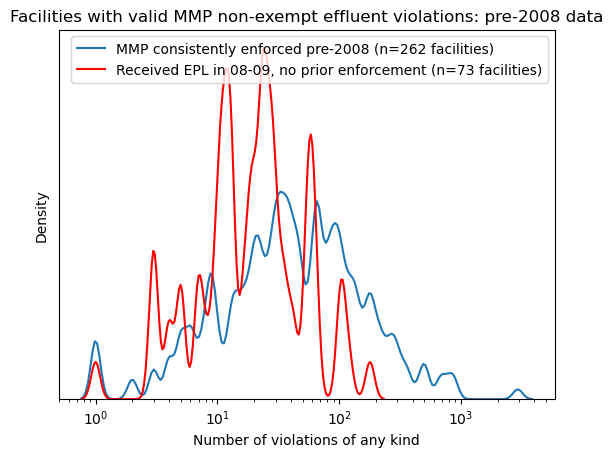

In [13]:
plt.style.use('default')
sns.kdeplot(
    data=comparison_B_violations[comparison_B_violations['OCCURRED ON'] < pd.to_datetime('2008-07-01')].groupby(
        'FACILITY_ID').nunique(),
    x='VIOLATION ID (VID)', bw_adjust=0.2, log_scale=True,
    label='MMP consistently enforced pre-2008 (n=' + str(len(comparison_B_facilities)) + ' facilities)');
sns.kdeplot(
    data=treatment_A_violations[(treatment_A_violations['OCCURRED ON'] < pd.to_datetime('2008-07-01'))].groupby(
        'FACILITY_ID').nunique(), x='VIOLATION ID (VID)', bw_adjust=0.2,
    log_scale=True, c='red', label='Received EPL in 08-09, no prior enforcement (n=' + str(len(treatment_A_facilities)) + ' facilities)');
plt.xlabel('Number of violations of any kind')
plt.yticks([])
plt.title('Facilities with valid MMP non-exempt effluent violations: pre-2008 data')
plt.legend();

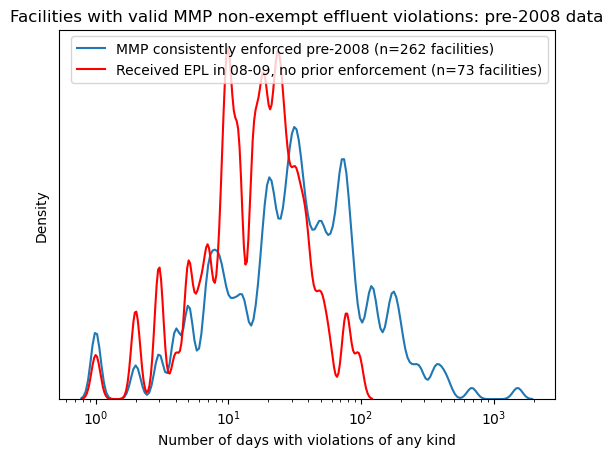

In [14]:
plt.style.use('default')
sns.kdeplot(
    data=comparison_B_violations[comparison_B_violations['OCCURRED ON'] < pd.to_datetime('2008-07-01')].groupby(
        'FACILITY_ID').agg(num_violation_days=pd.NamedAgg(column='OCCURRED ON', aggfunc=lambda x: x.nunique())), x='num_violation_days', log_scale=True, bw_adjust=0.2,
    label='MMP consistently enforced pre-2008 (n=' + str(len(comparison_B_facilities)) + ' facilities)');
sns.kdeplot(
    data=treatment_A_violations[(treatment_A_violations['OCCURRED ON'] < pd.to_datetime('2008-07-01'))].groupby(
        'FACILITY_ID').agg(num_violation_days=pd.NamedAgg(column='OCCURRED ON', aggfunc=lambda x: x.nunique())), x='num_violation_days', bw_adjust=0.2,
    log_scale=True, c='red', label='Received EPL in 08-09, no prior enforcement (n=' + str(len(treatment_A_facilities)) + ' facilities)');
plt.xlabel('Number of days with violations of any kind')
plt.yticks([])
plt.title('Facilities with valid MMP non-exempt effluent violations: pre-2008 data')
plt.legend();

Do pre-2008 violations in the two groups differ in terms of qualitative characteristics?

In [44]:
violation_results = pd.DataFrame()
for column in ['VIOLATION SUBTYPE', 'VIOLATION TYPE', 'MMP TYPE', 'VIOLATED FACILITY REGION']:
    violation_results = pd.concat([violation_results, compare_composition(
        comparison_B_violations[comparison_B_violations['OCCURRED ON'] < pd.to_datetime('2008-07-01')],
        treatment_A_violations[treatment_A_violations['OCCURRED ON'] < pd.to_datetime('2008-07-01')], column)])
violation_results.sort_values(by='diff', ascending=False, inplace=True)
violation_results

,Value,Comparison,Treatment,diff,p_value (prop_ztest),p_value (fishers_exact_test)
VIOLATED FACILITY REGION,4,0.26,0.90,0.64,0.000000e+00,0.000000e+00
MMP TYPE,Chronic,0.66,0.27,0.39,2.901703e-164,3.353775e-204
MMP TYPE,Serious,0.34,0.73,0.39,2.655980e-01,2.631631e-01
VIOLATION TYPE,Reporting,0.11,0.47,0.37,0.000000e+00,0.000000e+00
VIOLATION SUBTYPE,Deficient Reporting,0.09,0.37,0.28,0.000000e+00,1.788389e-242
VIOLATION TYPE,Effluent,0.77,0.50,0.27,3.325646e-171,4.846672e-150
VIOLATION SUBTYPE,OEV,0.34,0.14,0.20,6.748944e-66,1.905139e-75
VIOLATION SUBTYPE,CAT1,0.35,0.21,0.14,1.809396e-29,1.661949e-31
VIOLATED FACILITY REGION,3,0.06,0.01,0.06,8.137816e-29,3.380867e-44
VIOLATION TYPE,Order Conditions,0.05,0.01,0.04,2.177240e-20,2.029174e-29


What happens when we only include in the comparison group facilities in region 4?

In [47]:
violation_results = pd.DataFrame()
for column in ['VIOLATION SUBTYPE', 'VIOLATION TYPE', 'MMP TYPE']:
    violation_results = pd.concat([violation_results, compare_composition(
        comparison_B_violations[(comparison_B_violations['OCCURRED ON'] < pd.to_datetime('2008-07-01') ) &
                                (comparison_B_violations['VIOLATED FACILITY REGION']==4)],
        treatment_A_violations[treatment_A_violations['OCCURRED ON'] < pd.to_datetime('2008-07-01')], column)])
violation_results.sort_values(by='diff', ascending=False, inplace=True)
violation_results

,Value,Comparison,Treatment,diff,p_value (prop_ztest),p_value (fishers_exact_test)
MMP TYPE,Chronic,0.68,0.27,0.41,4.018558e-294,0.000000e+00
MMP TYPE,Serious,0.32,0.73,0.41,2.948781e-05,2.538468e-05
VIOLATION TYPE,Effluent,0.83,0.50,0.33,1.437020e-205,5.582096e-189
VIOLATION TYPE,Reporting,0.14,0.47,0.33,8.110728e-222,1.347739e-200
VIOLATION SUBTYPE,Deficient Reporting,0.09,0.37,0.29,1.502421e-211,3.726419e-184
VIOLATION SUBTYPE,OEV,0.41,0.14,0.28,8.920413e-117,1.192600e-130
VIOLATION SUBTYPE,CAT1,0.27,0.21,0.07,9.537730e-10,6.146171e-10
VIOLATION TYPE,Deficient Monitoring,0.01,0.02,0.01,3.523015e-02,4.703623e-02


### Testing Assumption: Treatment group has a parallel compliance pre-trend with the comparison group.

In [16]:
comparison_B_violations['Violation quarter'] = comparison_B_violations['OCCURRED ON'].dt.to_period('Q').astype(int)
treatment_A_violations['Violation quarter'] = treatment_A_violations['OCCURRED ON'].dt.to_period('Q').astype(int)

# Calculate number of violating facilities each quarter
to_plot_comparison = comparison_B_violations.groupby('Violation quarter', as_index=False).agg(
    n_violating_facilities=pd.NamedAgg(column='FACILITY_ID', aggfunc=lambda x: x.nunique()))
to_plot_treatment = treatment_A_violations.groupby('Violation quarter', as_index=False).agg(
    n_violating_facilities=pd.NamedAgg(column='FACILITY_ID', aggfunc=lambda x: x.nunique()))

# Calculate number of active facilities each quarter
to_plot_comparison['n_facilities_active'] = to_plot_comparison['Violation quarter'].apply(lambda x: len(
    # Facility has to have enrolled in NPDES on or before the quarter in question
    comparison_B_violations[(comparison_B_violations['estimated_entrance_quarter'] <= x) &
        # and NOT have a permit that has expired by the quarter in question
            (~(comparison_B_violations['estimated_exit_quarter'] <= x))].drop_duplicates('FACILITY_ID')))

# Same for treatment group
to_plot_treatment['n_facilities_active'] = to_plot_treatment['Violation quarter'].apply(lambda x: len(
    treatment_A_violations[(treatment_A_violations['estimated_entrance_quarter'] <= x) &
                (~(treatment_A_violations['estimated_exit_quarter'] <= x))].drop_duplicates('FACILITY_ID')))

# Divide violating # by active #
to_plot_comparison['Violation rate'] = to_plot_comparison['n_violating_facilities'] / to_plot_comparison[
    'n_facilities_active']
to_plot_treatment['Violation rate'] = to_plot_treatment['n_violating_facilities'] / to_plot_treatment[
    'n_facilities_active']

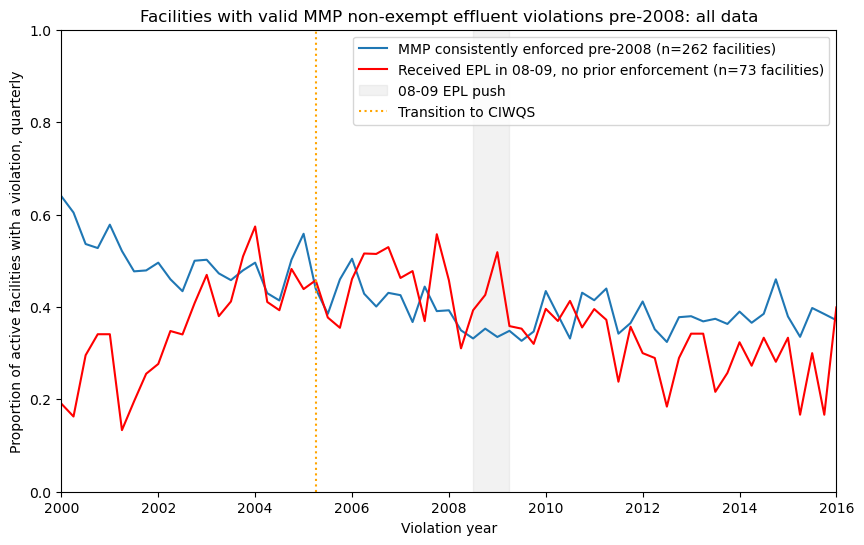

In [17]:
plt.style.use('default')
plt.figure(figsize=(10, 6))
plt.plot(to_plot_comparison['Violation quarter'], to_plot_comparison['Violation rate'],
         label='MMP consistently enforced pre-2008 (n=' + str(len(comparison_B_facilities)) + ' facilities)');
plt.plot(to_plot_treatment['Violation quarter'], to_plot_treatment['Violation rate'],
         label='Received EPL in 08-09, no prior enforcement (n=' + str(len(treatment_A_facilities)) + ' facilities)', color='red');

plt.fill_betweenx([0, 1], 154, 157, alpha=0.2, color='silver',
                  label='08-09 EPL push')
plt.axvline(x=141, linestyle=':', color='orange', label='Transition to CIWQS')
plt.ylabel('Proportion of active facilities with a violation, quarterly')
plt.ylim((0, 1))
plt.xlim((120, 184))
plt.xticks(list(range(120, 192, 8)), [2000, 2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016])
plt.xlabel('Violation year')
plt.title('Facilities with valid MMP non-exempt effluent violations pre-2008: all data')
plt.legend();

This iteration is distinct because it divides by # of active facilities, not just total # facilities.

Same data below, just plotted by yearly % of facilities violating

In [18]:
comparison_B_violations['Violation year'] = comparison_B_violations['OCCURRED ON'].dt.year
treatment_A_violations['Violation year'] = treatment_A_violations['OCCURRED ON'].dt.year

# Calculate number of violating facilities each quarter
to_plot_comparison = comparison_B_violations.groupby('Violation year', as_index=False).agg(
    n_violating_facilities=pd.NamedAgg(column='FACILITY_ID', aggfunc=lambda x: x.nunique()))
to_plot_treatment = treatment_A_violations.groupby('Violation year', as_index=False).agg(
    n_violating_facilities=pd.NamedAgg(column='FACILITY_ID', aggfunc=lambda x: x.nunique()))

# Calculate number of active facilities each quarter
to_plot_comparison['n_facilities_active'] = to_plot_comparison['Violation year'].apply(lambda x: len(
    # Facility has to have enrolled in NPDES on or before the year in question
    comparison_B_violations[(comparison_B_violations['estimated_entrance_date'].dt.year <= x) &
        # and NOT have a permit that has expired before the year in question
            (~(comparison_B_violations['estimated_exit_date'].dt.year < x))].drop_duplicates('FACILITY_ID')))

# Same for treatment group
to_plot_treatment['n_facilities_active'] = to_plot_treatment['Violation year'].apply(lambda x: len(
    treatment_A_violations[(treatment_A_violations['estimated_entrance_date'].dt.year <= x) &
                (~(treatment_A_violations['estimated_exit_date'].dt.year < x))].drop_duplicates('FACILITY_ID')))

# Divide violating # by active #
to_plot_comparison['Violation rate'] = to_plot_comparison['n_violating_facilities'] / to_plot_comparison[
    'n_facilities_active']
to_plot_treatment['Violation rate'] = to_plot_treatment['n_violating_facilities'] / to_plot_treatment[
    'n_facilities_active']

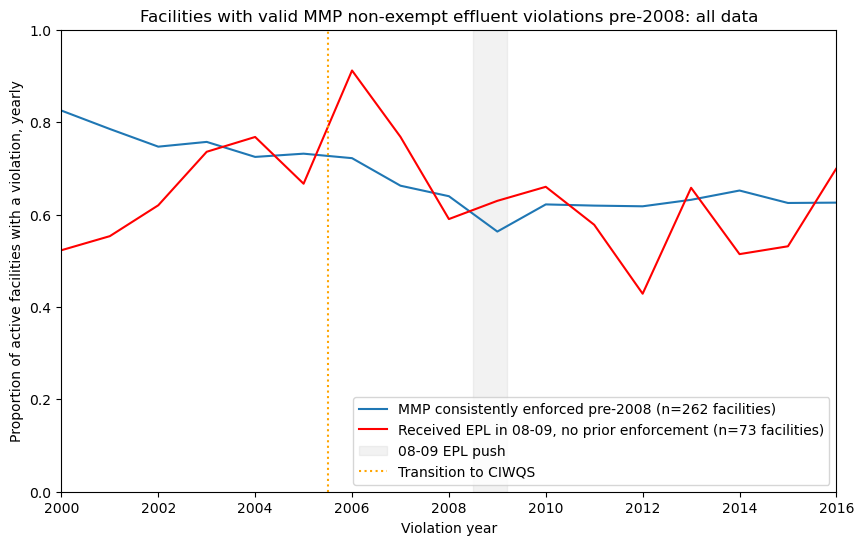

In [19]:
plt.style.use('default')
plt.figure(figsize=(10, 6))
plt.plot(to_plot_comparison['Violation year'], to_plot_comparison['Violation rate'],
         label='MMP consistently enforced pre-2008 (n=' + str(len(comparison_B_facilities)) + ' facilities)');
plt.plot(to_plot_treatment['Violation year'], to_plot_treatment['Violation rate'],
         label='Received EPL in 08-09, no prior enforcement (n=' + str(len(treatment_A_facilities)) + ' facilities)', color='red');

plt.fill_betweenx([0, 1], 2008.5, 2009.2, alpha=0.2, color='silver',
                  label='08-09 EPL push')
plt.axvline(x=2005.5, linestyle=':', color='orange', label='Transition to CIWQS')
plt.ylabel('Proportion of active facilities with a violation, yearly')
plt.ylim((0, 1))
plt.xlim((2000, 2016))
plt.xlabel('Violation year')
plt.title('Facilities with valid MMP non-exempt effluent violations pre-2008: all data')
plt.legend();

### Testing Assumption: Composition of the treatment and comparison groups doesn’t change pre/post treatment period.



Check: what does the trend in # active facilities look like?

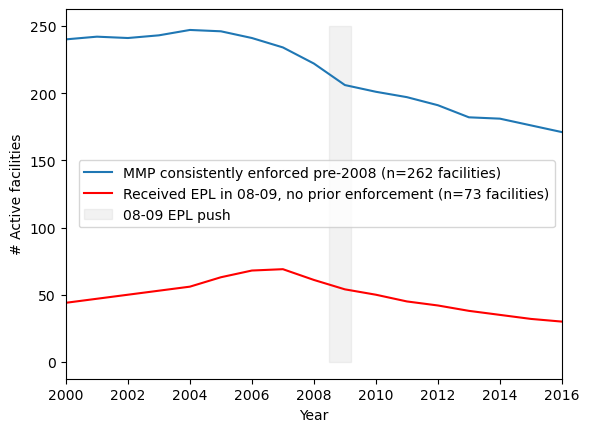

In [20]:
plt.style.use('default')
plt.plot(to_plot_comparison['Violation year'], to_plot_comparison['n_facilities_active'],
         label='MMP consistently enforced pre-2008 (n=' + str(len(comparison_B_facilities)) + ' facilities)');
plt.plot(to_plot_treatment['Violation year'], to_plot_treatment['n_facilities_active'],
         label='Received EPL in 08-09, no prior enforcement (n=' + str(len(treatment_A_facilities)) + ' facilities)', color='red');
plt.ylabel('# Active facilities')
plt.xlim((2000, 2016))
plt.fill_betweenx([0, 250], 2008.5, 2009.2, alpha=0.2, color='silver',
                  label='08-09 EPL push')
plt.xlabel('Year')
plt.legend();

Follow-up question: do we see facilities in our treatment group dropping out after their first MMP enforcement?

In [ ]:
# Filter enforcement actions just to our treatment group and to MMP enforcement actions
enforcements = enforcements[(enforcements['TOTAL MMP VIOLATIONS #'] > 0)].merge(treatment_A_violations[['FACILITY_ID']], on='FACILITY_ID')

In [95]:

first_enforcements = enforcements.groupby('FACILITY_ID', as_index=False).min()
first_enforcements['First enforcement date'] = first_enforcements[['EFFECTIVE DATE.1', 'ACL ISSUANCE DATE', 'EPL ISSUANCE DATE']].min(axis=1)

In [96]:
test = treatment_A_violations.merge(first_enforcements, on='FACILITY_ID')
test.drop_duplicates(subset=['FACILITY_ID'], inplace=True)

KeyError: 'First enforcement'

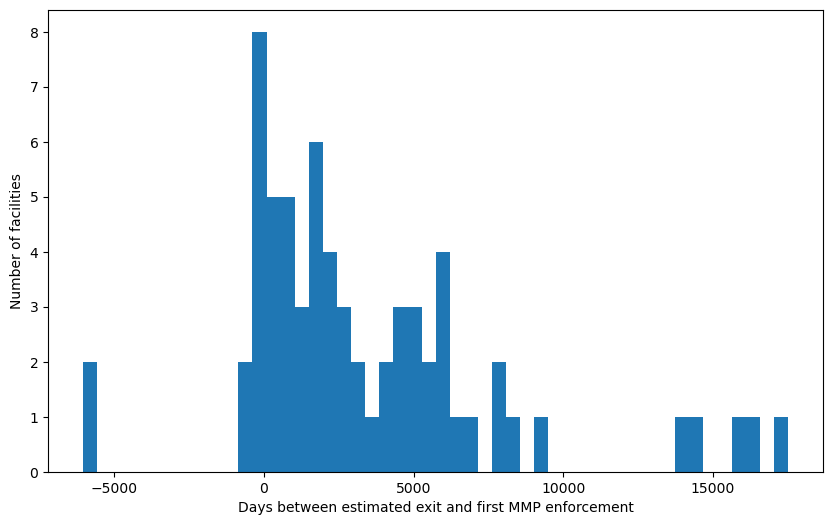

In [98]:
plt.figure(figsize=(10, 6))
plt.hist((test['estimated_exit_date']-test['First enforcement date']).dt.days, bins=50);
plt.xlabel('Days between first MMP enforcement and estimated exit')
plt.ylabel('Number of facilities')
plt.title('Treatment group (facilities receiving EPLs in 08-09 as their first MMP enforcement) \n (n=' + str(len(~pd.isna((test['estimated_exit_date']-test['First enforcement date']).dt.days))) + ' facilities with estimated exit dates)');

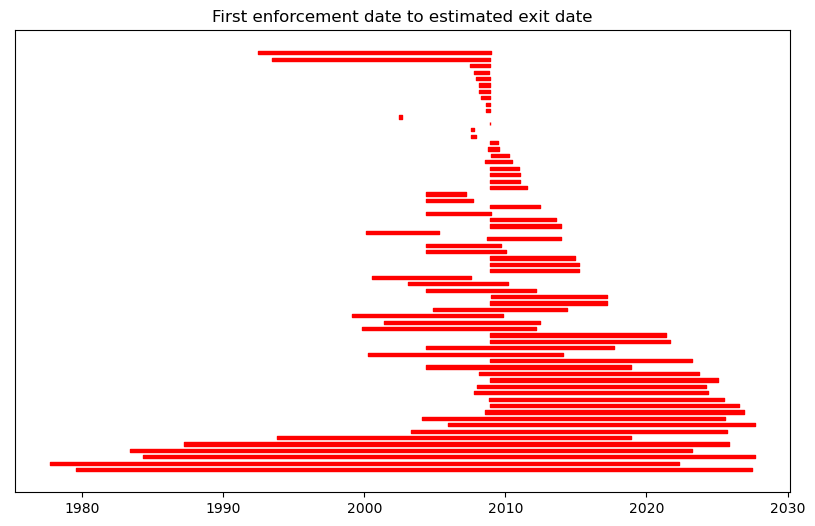

In [105]:
plt.figure(figsize=(10, 6))
test['time_diff'] = (test['estimated_exit_date']-test['First enforcement date']).dt.days
test.sort_values(by='time_diff', ascending=False, inplace=True)
for i in range(0, len(test[['First enforcement date','estimated_exit_date']].dropna())):
    plt.fill_betweenx([i+1, i+1.5], test[['First enforcement date','estimated_exit_date']].dropna()['First enforcement date'].iloc[i], test[['First enforcement date','estimated_exit_date']].dropna()['estimated_exit_date'].iloc[i], color='red')
plt.ylabel('')
plt.yticks([])
plt.title('First enforcement date to estimated exit date');

In [104]:
test

,VIOLATED FACILITY REGION,REGULATED FACILITY REGION,FACILITY_ID,FACILITY NAME_x,AGENCY NAME,PLACE TYPE_x,PLACE SUBTYPE_x,FACILITY TYPE_x,AGENCY TYPE,NUMBER OF AGENCIES,PLACE ADDRESS_x,PLACE CITY_x,PLACE ZIP_x,PLACE COUNTY_x,PLACE LATITUDE_x,PLACE LONGITUDE_x,SIC CODE 1_x,SIC DESC 1_x,SIC CODE 2_x,SIC DESC 2_x,SIC CODE 3_x,SIC DESC 3_x,NAICS CODE 1_x,NAICS DESC 1_x,NAICS CODE 2_x,NAICS DESC 2_x,NAICS CODE 3_x,NAICS DESC 3_x,NUMBER OF PLACES,DESIGN FLOW_x,THREAT TO WATER QUALITY_x,COMPLEXITY,PRETREATMENT,FACILITY WASTE TYPE,FACILITY WASTE TYPE 2,FACILITY WASTE TYPE 3,FACILITY WASTE TYPE 4,PROGRAM,PROGRAM CATEGORY,NUMBER OF PROGRAMS,WDID,REG MEASURE ID_x,REG MEASURE TYPE,TITLE_x,DESCRIPTION,ORDER NUMBER,NPDES# CA#,MAJOR-MINOR,NPDES TYPE,RECLAMATION,DREDGE FILL FEE_x,301H,APPLICATION FEE AMT RECEIVED_x,STATUS,STATUS DATE,EFFECTIVE DATE,EXPIRATION/REVIEW DATE,TERMINATION DATE,ADOPTION DATE,WDR REVIEW - AMEND,WDR REVIEW - REVISE/RENEW,WDR REVIEW - RESCIND,WDR REVIEW - NO ACTION REQUIRED,WDR REVIEW - PENDING_x,WDR REVIEW - PLANNED_x,STATUS ENROLLEE_x,INDIVIDUAL/GENERAL,FEE CODE,STAFF ASSIGNED,NUMBER OF STAFF ASSIGNED,SUPERVISOR,NUMBER OF SUPERVISORS,VIOLATION ID (VID),VIOLATION TYPE,VIOLATION SUBTYPE,VIOLATION DESCRIPTION,VIOLATION COMMENTS,CORRECTIVE ACTION,STATUS.1,OCCURRED ON,DISCOVERY DATE,PROGRAM.1,PROGRAM CATEGORY.1,PRIORITY (Y/N),NPDES Serious (Y/N),Otherwise MMP (Y/N),EXEMPT (Y/N),Reason Exempt from MMPs,MMP TYPE,QNCR Reportable,Violation Source,Violation Source ID,Violation Rank,Parameter,Limit,Result,Units,Period,Monitoring Location,Number of Final (A+H) 13267,Number of Final (A+H) 13308,Number of Final (A+H) ACL,Number of Final (A+H) CDO,Number of Final (A+H) CAO,Number of Final (A+H) Expedited Payment Letters,Number of Final (A+H) Referrals to Attorney General,Number of Final (A+H) Notices of Stormwater Noncompliance,Number of Final (A+H) Notices of Violation,Number of Final (A+H) Notices to Comply,Number of Final (A+H) Oral Communications,Number of Final (A+H) Referrals to District Attorney,Number of Final (A+H) Referrals to Other Agency,Number of Final (A+H) Referrals to Task Force,Number of Final (A+H) Referrals to USEPA,Number of Final (A+H) Settlement Court Orders,Number of Final (A+H) Staff Enforcement Letter,Number of Final (A+H) Stipulated Penalties,Number of Final (A+H) Third Party Actions,Number of Final (A+H) Time Schedule Orders,Number of Final (A+H) Unknown,Number of Final (A+H) Waste Discharge Requirements,enroll_date,final_expiration_date,last_termination_date,estimated_entrance_date,estimated_entrance_quarter,estimated_exit_date,estimated_exit_quarter,Violation quarter,Violation year,REGION,FACILITY NAME_y,PLACE TYPE_y,PLACE SUBTYPE_y,FACILITY TYPE_y,# OF AGENCIES,PLACE ADDRESS_y,PLACE CITY_y,PLACE ZIP_y,PLACE COUNTY_y,PLACE LATITUDE_y,PLACE LONGITUDE_y,SIC CODE 1_y,SIC DESC 1_y,SIC CODE 2_y,SIC DESC 2_y,SIC CODE 3_y,SIC DESC 3_y,NAICS CODE 1_y,NAICS DESC 1_y,NAICS CODE 2_y,NAICS DESC 2_y,NAICS CODE 3_y,NAICS DESC 3_y,# OF PLACES,SOURCE OF FACILITY,DESIGN FLOW_y,THREAT TO WATER QUALITY_y,# OF PROGRAMS,REG MEASURE ID_y,DREDGE FILL FEE_y,APPLICATION FEE AMT RECEIVED_y,WDR REVIEW - PENDING_y,WDR REVIEW - PLANNED_y,STATUS ENROLLEE_y,# OF STAFF ASSIGNED,# OF SUPERVISORS,ENFORCEMENT ID (EID),ENFORCEMENT ACTION TYPE,EFFECTIVE DATE.1,ACL ISSUANCE DATE,EPL ISSUANCE DATE,TITLE_y,# OF PROGRAMS.1,# OF ASSIGNED STAFF,# OF SUPERVISORS.1,TOTAL ASSESSMENT AMOUNT,INITIAL ASSESSED AMOUNT,LIABILITY $ AMOUNT,PROJECT $ AMOUNT,LIABILITY $ PAID,PROJECT $ COMPLETED,TOTAL $ PAID/COMPLETED AMOUNT,DATE OF OLDEST VIOLATION LINKED TO ENFORCEMENT ACTION,RANK 1 VIOLATIONS,RANK 2 VIOLATIONS,RANK 3 VIOLATIONS,UNCLASSIFIED VIOLATIONS,ATOX VIOLATIONS #,BMP VIOLATIONS #,BASIN PLAN PROHIBITION VIOLATIONS #,CAT1 VIOLATIONS #,CAT2 VIOLATIONS #,CTOX VIOLATIONS #,DEFICIENT MONITORING VIOLATIONS #,DEFICIENT REPORT VIOLATIONS #,ENFORCEMENT ACTION VIOLATIONS #,FEES VIOLATIONS #,GROUNDWATER VIOLATIONS #,HYDRO MODIFICATION VIOLATIONS #,LATE REPORT VIO